# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the C02 emissions data

### 1. Importing your libraries and data

In [23]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.
from pylab import rcParams # This will define a fixed size for all special charts.
from datetime import datetime
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 


warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [24]:
# Configure API key 

quandl.ApiConfig.api_key = 'Jq61oqpNGH2oy-RMsDps'

In [25]:
# Importing the BP C02 Data "Total Europe" variable.

data = quandl.get('BP/C02_EMMISSIONS_EUR')

In [26]:
data.head(5)

,Value
Date,
1965-12-31,3427.810483
1966-12-31,3474.885568
1967-12-31,3543.858134
1968-12-31,3757.726642
1969-12-31,4008.326486


In [27]:
data.columns

Index(['Value'], dtype='object')

In [28]:
type(data)

pandas.core.frame.DataFrame

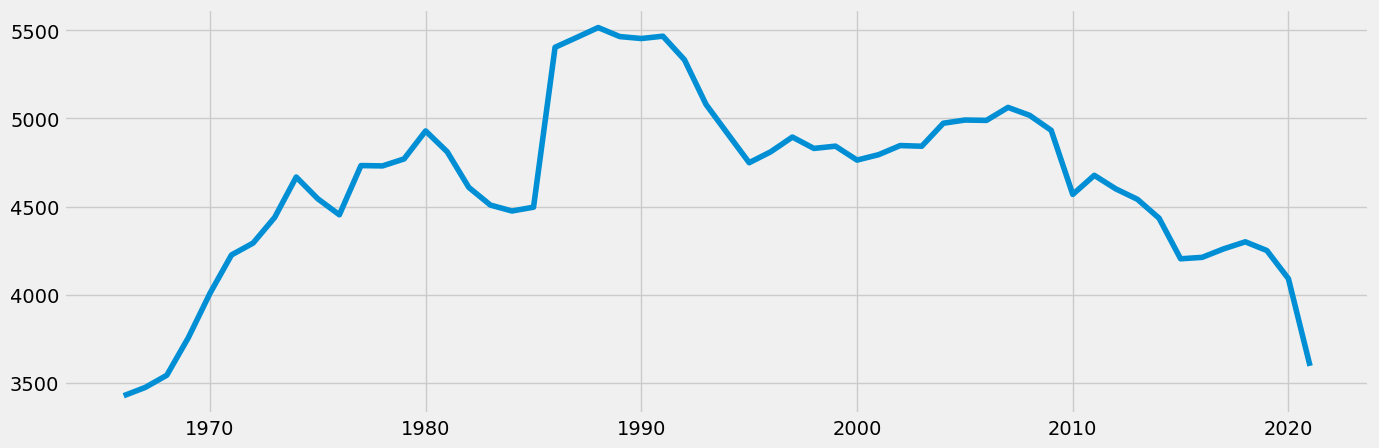

In [29]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [30]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [31]:
data_2.head()

,Date,Value
0,1965-12-31,3427.810483
1,1966-12-31,3474.885568
2,1967-12-31,3543.858134
3,1968-12-31,3757.726642
4,1969-12-31,4008.326486


In [32]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2022-01-01')]

In [33]:
data_sub.shape

(31, 2)

In [34]:
data_sub.head()

,Date,Value
25,1990-12-31,5466.313580
26,1991-12-31,5332.444441
27,1992-12-31,5078.844036
28,1993-12-31,4913.580229
29,1994-12-31,4749.054965


In [35]:
# Set the "Date" column as the index


data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-12-31,5466.313580
1991-12-31,5332.444441
1992-12-31,5078.844036
1993-12-31,4913.580229
1994-12-31,4749.054965


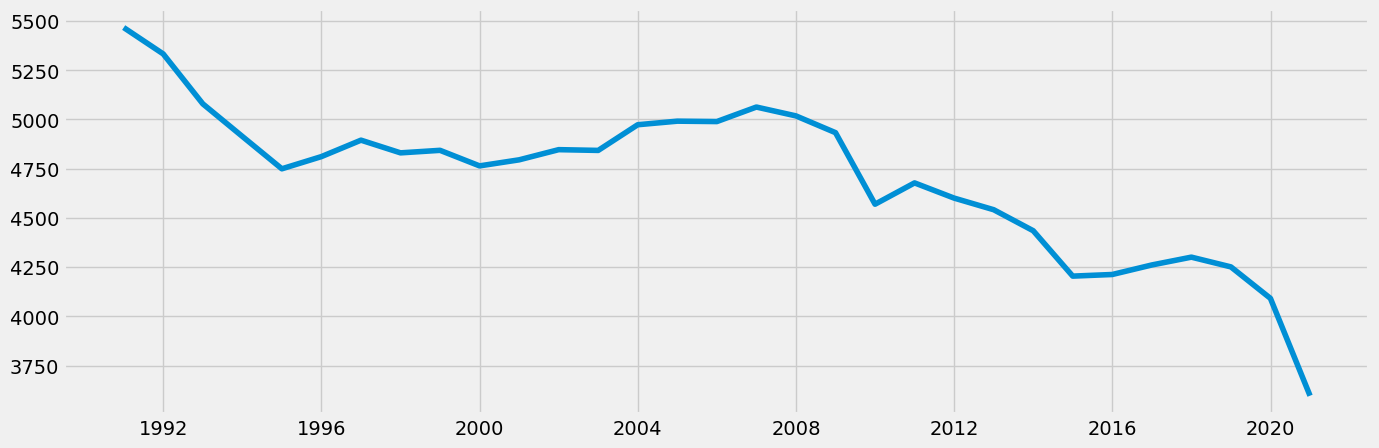

In [36]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [37]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [38]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [39]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
rcParams['figure.figsize'] = 18, 7

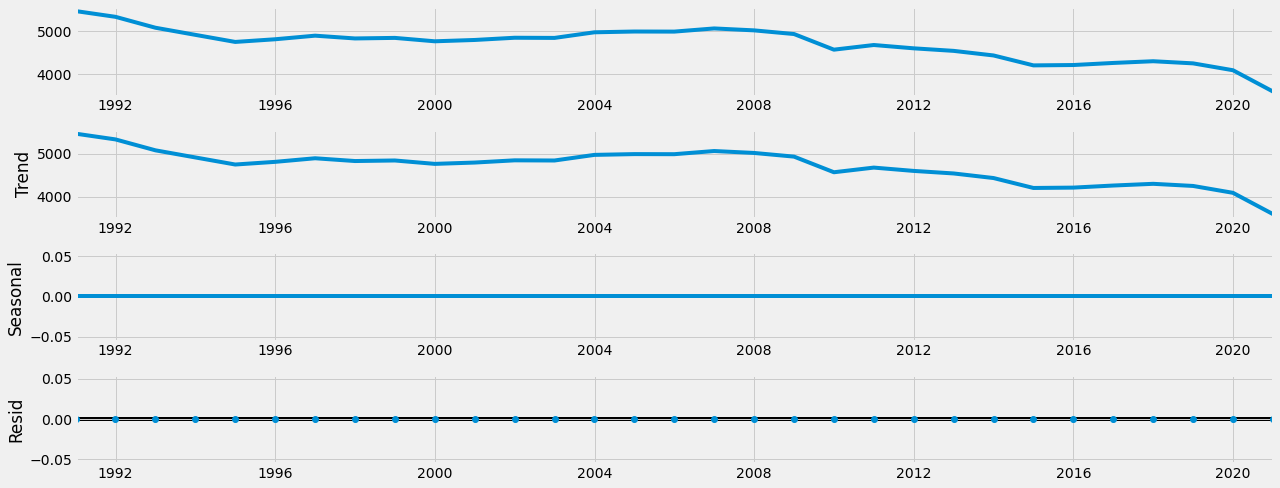

In [41]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The decompositiion shows no difference between the level and trend, indicating that there is no noise in the data. The seaonality line is flat indicating that there is no seasonality in the C02 emissions in Europe year over year, and the residual confirms the earlier conclusion that there is no noise in the data.

### 4. Testing for stationarity


In [43]:
# Running a Dickey-Fuller test to check for presence of unit root (testing non-stationarity)
def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.193842
p-value                         0.971914
Number of Lags Used             0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


#### When interpreting the results of the Dickey-Fuller test, the Test Statistic of .193842 is larger than the Critical Value at 5% significance level. This mean that the null hypothesis that there is no unit root can't be rejected. The data as it exists is non-stationary. The p-value of .971914 is also larger than .05 indicating it is not significant.




Interpret the results in a markdown cell and reference your null hypothesis.

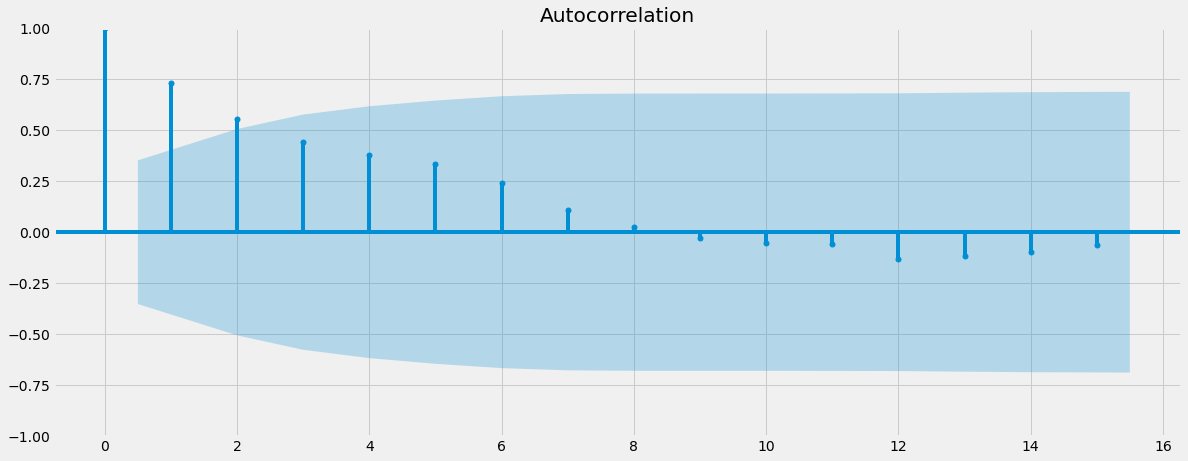

In [44]:
# Check out a plot of autocorrelations

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the C02 emissions data

In [53]:
data_diff = data_sub - data_sub.shift(1)

In [54]:
data_diff.dropna(inplace = True) 

In [55]:
data_diff.head()

,Value
datetime,
1991-12-31,-133.869139
1992-12-31,-253.600405
1993-12-31,-165.263807
1994-12-31,-164.525264
1995-12-31,61.912854


In [56]:
data_diff.columns

Index(['Value'], dtype='object')

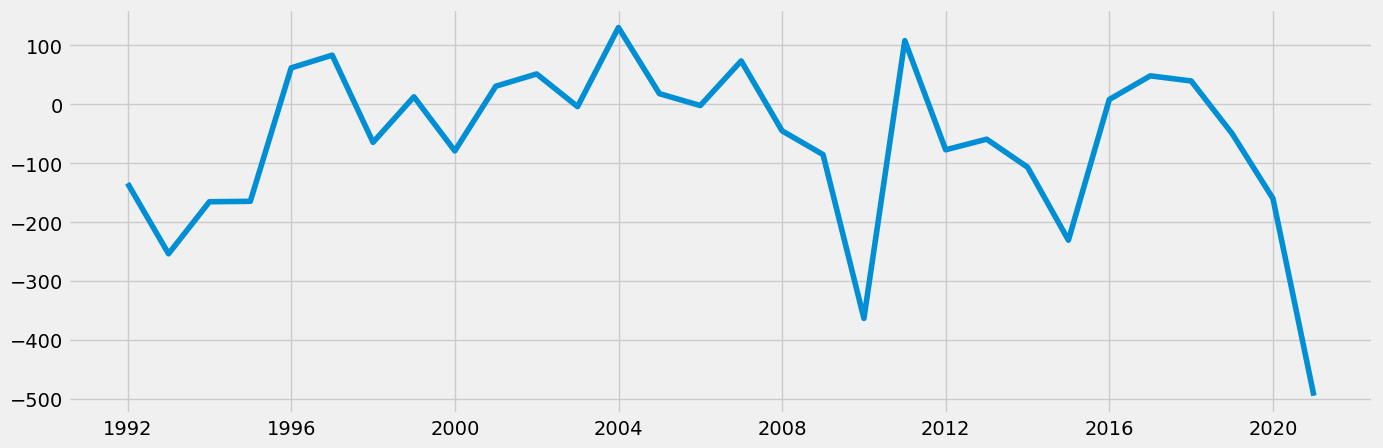

In [57]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [58]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.062876
p-value                         0.029425
Number of Lags Used             0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


#### After stationarizing the data using the differencing technique, rerunning the Dickey-Fuller test shows that the data is now stationary. The Test Statistic is now lower than the Critical Value and the p-value is significant.

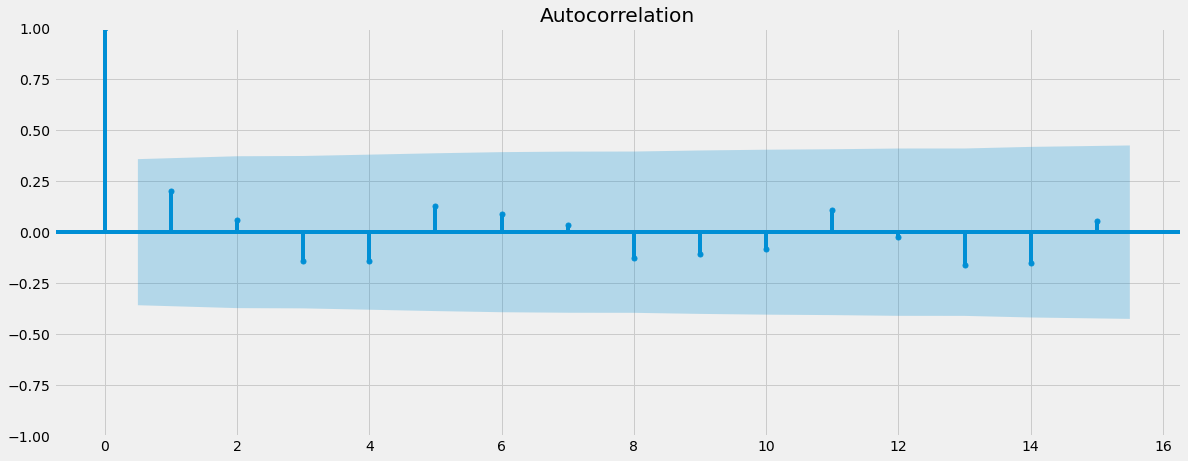

In [59]:
plot_acf(data_diff)
plt.show()